<a href="https://colab.research.google.com/github/klostesu/github-example/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example using nltk for preprocessing text

**NOTE:**
You will be prompted to upload a text file from your Google Drive.

If you would like to use the file that was used in this example, copy it from this link to your Google Drive:

https://github.com/gal-a/blog/blob/master/docs/notebooks/nlp/data/quotes.txt

In [1]:
# Setup
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

## Load the corpus file from Google Drive

In [4]:
# Upload from google drive
from google.colab import files
uploaded = files.upload()
print("len(uploaded.keys():", len(uploaded.keys()))

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Get list of quotes
df_quotes = pd.read_csv(io.StringIO(uploaded['quotes.txt'].decode('utf-8')), sep='\t')

# Display
print("df_quotes:")
print(df_quotes.head().to_string())
print(df_quotes.describe())

# Convert quotes to list
li_quotes = df_quotes['Quote'].tolist()
print()
print("len(li_quotes):", len(li_quotes))

Saving quotes.txt to quotes.txt
len(uploaded.keys(): 1
User uploaded file "quotes.txt" with length 6984 bytes
df_quotes:
            Author                                                                                                                                                                                      Quote
0  Agatha Christie  I like living. I have sometimes been wildly, despairingly, acutely miserable, racked with sorrow; but through it all I still know quite certainly that just to be alive is a grand thing.
1  Agatha Christie                                                                                The impossible could not have happened, therefore the impossible must be possible in spite of appearances. 
2  Agatha Christie                                                                                                       Poirot, I said. I have been thinking. An admirable exercise my friend. Continue it. 
3  Agatha Christie                                     

## Tokenize sentences and words, remove stopwords, use stemmer & lemmatizer

First, a note on the difference between Stemming vs Lemmatization:

* Stemming: Trying to shorten a word with simple regex rules

* Lemmatization: Trying to find the root word with linguistics rules (with the use of regex rules)

In [8]:
# Get stopwords, stemmer and lemmatizer
# Get stopwords, stemmer and lemmatizer
# Get stopwords, stemmer and lemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' resource.
nltk.download('averaged_perceptron_tagger_eng') # Download the missing 'averaged_perceptron_tagger_eng' resource

stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# ... (rest of the code remains the same)

# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(li_quotes):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)

        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]

                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1]
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)

    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)

# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)

print("df_token_lists.head(5):")
print(df_token_lists.head(5).to_string())

# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])

print()
print("")
print("df_lem_strings.head():")
print(df_lem_strings.head().to_string())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


df_token_lists.head(5):
        0           1       2          3         4         5          6          7         8           9             10         11        12         13      14      15           16      17    18    19       20    21    22    23     24    25     26         27    28    29    30    31     32    33    34     35     36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113
0         i        like  living                    i      have  sometimes       been    wildly              despairingly              acutely  miserable          racked         with  sorrow        

<ipython-input-8-7aaa23db1ea6>:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_token_lists[c].fillna(value='', inplace=True)


## Process results, find the most popular lemmatized words and group results by Part of Speech (POS)

In [9]:
# Add counts
print("Group by lemmatized words, add count and sort:")
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

print("Get just the first row in each lemmatized group")
df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(10):")
print(df_words.head(10))

Group by lemmatized words, add count and sort:
Get just the first row in each lemmatized group
df_words.head(10):
          lem  index       token    stem pos  counts
0      always     50      always   alway  RB      10
1     nothing    116     nothing    noth  NN       6
2        life     54        life    life  NN       6
3         man     74         man     man  NN       5
4        give     39        gave    gave  VB       5
5       world    121       world   world  NN       5
6        fact    106        fact    fact  NN       5
7  impossible     15  impossible  imposs  JJ       4
8         say     23        said    said  VB       4
9        come    180       comes    come  VB       4


## Top 10 words per Part Of Speech (POS)

In [10]:
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(10).to_string())


POS_TYPE: NN
          lem pos  counts
1     nothing  NN       6
2        life  NN       6
3         man  NN       5
5       world  NN       5
6        fact  NN       5
10  happiness  NN       4
11      woman  NN       4
12     theory  NN       4
13       work  NN       4
14      order  NN       3

POS_TYPE: JJ
            lem pos  counts
7    impossible  JJ       4
16      certain  JJ       3
18      curious  JJ       3
32         best  JJ       2
37       little  JJ       2
44         nice  JJ       2
53         good  JJ       2
59   improbable  JJ       2
72         able  JJ       1
74  accountable  JJ       1

POS_TYPE: VB
       lem pos  counts
4     give  VB       5
8      say  VB       4
9     come  VB       4
21    make  VB       3
22     see  VB       3
24   think  VB       3
39    lose  VB       2
47    take  VB       2
55  ignore  VB       2
56    know  VB       2

POS_TYPE: RB
          lem pos  counts
0      always  RB      10
15    however  RB       3
19      still  RB  

## Sorted frequency plot for all words

li_token_lists_flat[:10]: ['i', 'like', 'living', '', 'i', 'have', 'sometimes', 'been', 'wildly', '']
[('the', 51), ('is', 36), ('to', 33), ('a', 27), ('i', 25), ('and', 25), ('it', 23), ('in', 20), ('that', 19), ('be', 18), ('of', 18), ('you', 17), ('but', 14), ('have', 13), ('not', 12), ('he', 12), ('one', 11), ('all', 10), ('always', 10), ('there', 10), ('for', 9), ('will', 9), ('me', 9), ('when', 8), ('they', 8), ('like', 7), ('with', 7), ('must', 7), ('my', 7), ('do', 7), ('was', 7), ('we', 7), ('what', 7), ('life', 6), ('if', 6), ('nothing', 6), ('his', 6), ('most', 5), ('are', 5), ('s', 5), ('man', 5), ('has', 5), ('world', 5), ('am', 5), ('would', 5), ('impossible', 4), ('said', 4), ('can', 4), ('give', 4), ('nt', 4), ('who', 4), ('happiness', 4), ('only', 4), ('more', 4), ('this', 4), ('any', 4), ('or', 4), ('work', 4), ('still', 3), ('an', 3), ('certain', 3), ('truth', 3), ('however', 3), ('curious', 3), ('them', 3), ('fit', 3), ('facts', 3), ('never', 3), ('felt', 3), ('may'

<Axes: xlabel='Samples', ylabel='Counts'>

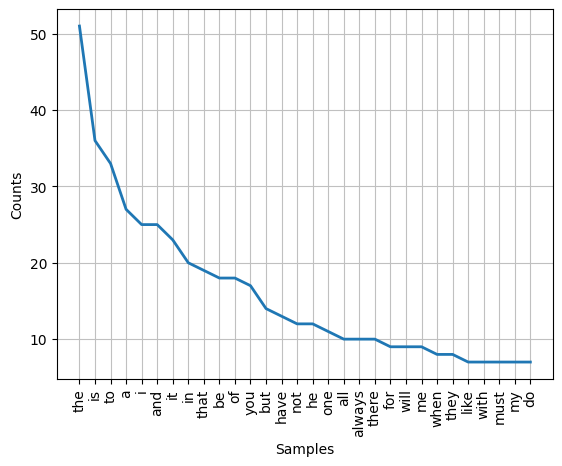

In [11]:
li_token_lists_flat = [y for x in li_token_lists for y in x]  # flatten the list of token lists to a single list
print("li_token_lists_flat[:10]:", li_token_lists_flat[:10])

di_freq = nltk.FreqDist(li_token_lists_flat)
del di_freq['']
li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted)

di_freq.plot(30, cumulative=False)

## ## Sorted frequency plot for Lemmatized  words after removing stopwords

[('always', 10), ('life', 6), ('nothing', 6), ('fact', 5), ('give', 5), ('man', 5), ('world', 5), ('come', 4), ('happiness', 4), ('impossible', 4), ('say', 4), ('theory', 4), ('woman', 4), ('work', 4), ('certain', 3), ('curious', 3), ('felt', 3), ('fit', 3), ('holmes', 3), ('however', 3), ('make', 3), ('never', 3), ('order', 3), ('see', 3), ('sherlock', 3), ('still', 3), ('think', 3), ('truth', 3), ('adler', 2), ('artist', 2), ('attention', 2), ('best', 2), ('die', 2), ('dog', 2), ('dull', 2), ('eliminate', 2), ('emotion', 2), ('fine', 2), ('friend', 2), ('good', 2), ('help', 2), ('ignore', 2), ('imagination', 2), ('improbable', 2), ('incident', 2), ('irene', 2), ('know', 2), ('little', 2), ('living', 2), ('lose', 2), ('love', 2), ('mind', 2), ('nice', 2), ('nighttime', 2), ('observe', 2), ('perfect', 2), ('person', 2), ('quite', 2), ('really', 2), ('reason', 2), ('remains', 2), ('storm', 2), ('suit', 2), ('take', 2), ('tea', 2), ('thing', 2), ('time', 2), ('watson', 2), ('wish', 2), (

<Axes: xlabel='Samples', ylabel='Counts'>

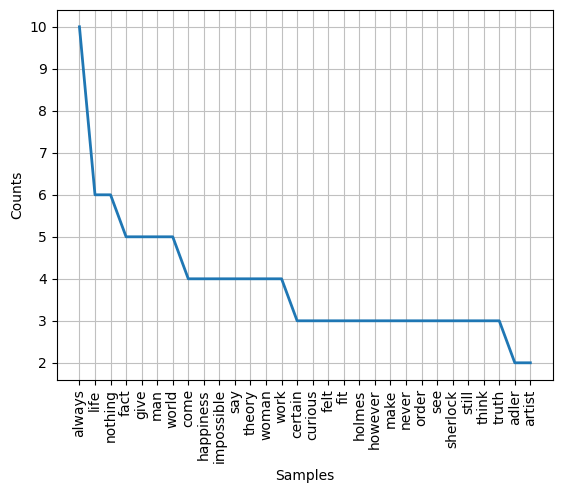

In [12]:
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted2)

di_freq2.plot(30, cumulative=False)